In [1]:
import numpy as np
from numpy import abs, sqrt, log10, sin, cos, exp, cosh, tanh, log, conj, cosh, sinh
np.set_printoptions(precision=16)
from math import pi, factorial
from numpy.random import rand
from numpy.linalg import norm
import scipy
import scipy.sparse as sp
from scipy.sparse import linalg, csc_matrix
import time
from scipy.optimize import minimize
from scipy.special import eval_hermite

%matplotlib inline
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
#mpl.rcParams["figure.dpi"] = 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

import pickle

from qonn_cobyla import *

from qutip import *

import matplotlib as mpl

from matplotlib import cm

from numpy import array
from numpy import count_nonzero

from scipy.signal import find_peaks, savgol_filter

In [2]:
def get_wigner(psi):
    '''
    This function gets the Wigner quasiprobability distribution of the pure state psi (in QuTiP).
    '''

    rho = psi[:, np.newaxis] @ psi[np.newaxis, :].conj()

    # We trace out the second mode
    basis_1 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    basis_2 = csc_matrix(np.eye(N_p+1, dtype=np.complex128))
    rho_1 = 0 # Initialize reduced density matrix of mode 1
    for j in range(N_p+1):
        rho_1 += sp.kron(basis_2[:, j].H, basis_1) @ rho @ sp.kron(basis_2[:, j], basis_1)

    rho_1_qutip = Qobj(rho_1)
    xvec = np.linspace(-sqrt(N_p), sqrt(N_p), 200)
    W_1 = wigner(rho_1_qutip, xvec, xvec)

    return W_1

In [3]:
def QFI_explicit(psi):
    '''
    This function calculates the QFI of the pure state psi.
    '''

    psi_phi = np.copy(psi)
    # Encoding (MZ interferometer)
    psi_phi = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d_c, dtype=np.complex128) + setup.H_BS_sym()), psi_phi)
    psi_phi = sp.linalg.expm_multiply(-1j * (phi[1] * setup.H_phi() ), psi_phi)
    psi_phi = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d_c, dtype=np.complex128) + setup.H_BS_sym()), psi_phi)
    
    psi_delta = np.copy(psi)
    # Encoding (MZ interferometer)
    psi_delta = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d_c, dtype=np.complex128) + setup.H_BS_sym()), psi_delta)
    psi_delta = sp.linalg.expm_multiply(-1j * (phi_delta[1] * setup.H_phi() ), psi_delta)
    psi_delta = sp.linalg.expm_multiply(-1j * (0*sp.eye(setup.d_c, dtype=np.complex128) + setup.H_BS_sym()), psi_delta)

    # Evaluate QFI
    F = np.abs(psi_phi[np.newaxis, :].conj() @ psi_delta[:, np.newaxis])
    cost = (8*(1-F)/delta**2)[0][0]

    return cost

0.49952488122030514
0.999599899974994
1.4996749187296827


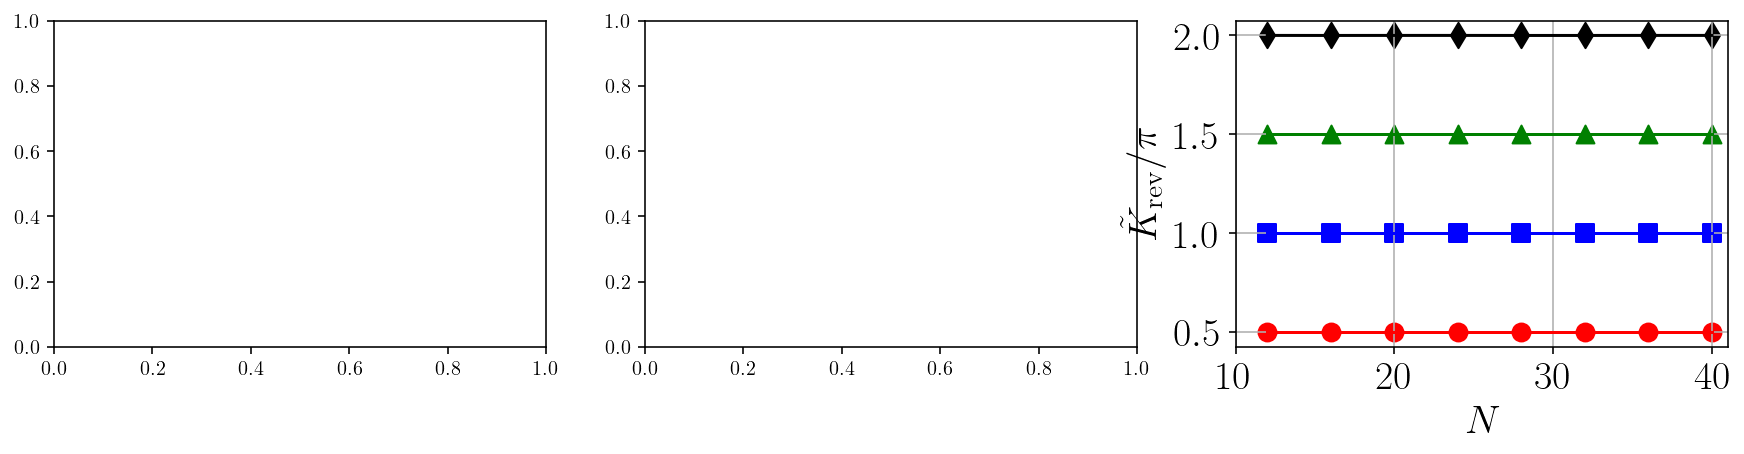

In [4]:
k = 2

ordinals = ['st', 'nd', 'rd', 'th']
colors = ['red', 'blue', 'green', 'black']
markers = ['o', 's', '^', 'd']

# We plot the ultimate estimation error given by the QFI
N_p_list = [20, 40, 80]
plt.rcParams["figure.figsize"] = [5*len(N_p_list), 3]
fig, ax = plt.subplots(1, len(N_p_list))
marker_size = 80
fs = 20

ax[-1].grid()
ax[-1].tick_params(axis='both', labelsize=fs)
ax[-1].set_xlim(10, 41)
ax[-1].set_xticks(np.arange(10, 50, 10))
ax[-1].set_ylabel(r'$\tilde{K}_{\rm rev}/\pi$', fontsize=fs)

file = open('T_rev_k={:}'.format(k), 'rb')
input = pickle.load(file)
file.close()

T_rev_matrix = input[0]
N_list = input[1]/2
indices = input[2]

for i in range(len(indices[:-1])):
    ax[-1].scatter(N_list[2:], T_rev_matrix[:, i]/pi, marker_size, label='{:}'.format(i+1) + ordinals[i] + ' revival', color=colors[i], marker=markers[i])
    ax[-1].plot(N_list[2:], T_rev_matrix[:, i]/pi, color=colors[i])

    print(T_rev_matrix[0, i]/pi)

# 4th revival

i += 1

file = open('T_rev_k={:}_faster_4th_rev.p'.format(k), 'rb')
input = pickle.load(file)
file.close()

T_rev_matrix = input[0]
N_list = input[1]/2
indices = input[2]

ax[-1].scatter(N_list[2:], T_rev_matrix[0][2:]/pi, marker_size, label='{:}'.format(i+1) + ordinals[i] + ' revival'.format(i+1), color=colors[-1], marker=markers[-1])
ax[-1].plot(N_list[2:], T_rev_matrix[0][2:]/pi, color=colors[-1])

ax[-1].set_xlabel(r'$N$', fontsize=fs)

#ax[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fs)

plt.savefig('Figure 3 v2 panel c.svg', bbox_inches='tight', dpi=600)